<a href="https://colab.research.google.com/github/NahuelCostaCortez/rapidae/blob/main/examples/START_HERE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installation

First, let´s install the library.

In [ ]:
%pip install rapidae

This installs the latest stable version. If you want to have control over the code you can check [execute_from_source_code]("https://colab.research.google.com/github/NahuelCostaCortez/rapidae/blob/main/examples/execute_from_source_code.ipynb").

You will also need to install a backend framework

**If you executing this from colab** Tensorflow, Pytorch and JAX are already installed so **you can skip this process**.

#### Install tensorflow

In [ ]:
!python3 -m pip install tensorflow[and-cuda]

After installing tensorflow Keras 3 should be re-installed. This is a temporary step while TensorFlow is pinned to Keras 2, and will no longer be necessary after TensorFlow 2.16. The cause is that tensorflow==2.15 will overwrite your Keras installation with keras==2.15.

In [ ]:
!pip install --upgrade keras

#### Install pytorch

In [ ]:
!pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu118

#### Install JAX

In [ ]:
!pip install --upgrade pip
!pip install --upgrade "jax[cpu]" # CPU-only version
# pip install --upgrade "jax[cuda11_pip]" # NVIDIA GPU version

### Data

Typically, for an experiment you need:

- data
- model

The library has a module for each. Let´s start loading some data

In [12]:
from rapidae.data import load_MNIST
from keras import utils

All datasets have a "persistant" parameter. If set to True stores the data in a newly created "datasets" folder. Default: False.

In [17]:
# Load MNIST dataset
x_train, y_train, x_test, y_test = load_MNIST() # persistant=True stores the data

2024-01-18 19:14:36 [INFO]: Downloading train-images-idx3-ubyte.gz...
2024-01-18 19:14:36 [INFO]: Downloading train-labels-idx1-ubyte.gz...
2024-01-18 19:14:36 [INFO]: Downloading t10k-images-idx3-ubyte.gz...
2024-01-18 19:14:36 [INFO]: Downloading t10k-labels-idx1-ubyte.gz...
2024-01-18 19:14:37 [INFO]: Deleting MNIST data...


Prepare data for training:
- Normalize data in the range [0,1]
- Convert labels to categorical

In [18]:
# Normalize data and flatten images
x_train = x_train.reshape(x_train.shape[0], -1).astype("float32") / 255
x_test = x_test.reshape(x_test.shape[0], -1).astype("float32") / 255

input_dim = x_train.shape[1]

# Obtaint number of clasess
n_classes = len(set(y_train))

# Convert labels to categorical
y_train = utils.to_categorical(y_train, n_classes)
y_test = utils.to_categorical(y_test, n_classes)

### Models

You can list available models with the function ```list_models()```.

Note however, that these are the base models, for a complete guide of the implemented models, please refer to the documentation or the README of the official repo.

In [51]:
from rapidae.models import list_models

In [6]:
list_models()

['AE', 'CAE', 'VAE', 'VQVAE']

Let´s build a simple autoencoder.

Each model needs typically an encoder and a decoder (some models don´t need an encoder or a decoder, but let´s skip that part). You can select among the available architectures in the models module or provide your own implementation

#### Selecting an existing architecture

In [52]:
from rapidae.models import AE

Each model has at least the following parameters:

- input_dim (Union[Tuple[int, ...], None]): The dimensionality of the input data. Default is None. **Required parameter**.
- latent_dim (int): The dimensionality of the latent space. Default is 2.
- encoder (BaseEncoder): An instance of BaseEncoder. Default is None. If no encoder is provided the BaseEncoder will be the chosen architecture.
- decoder (BaseDecoder): An instance of BaseDecoder. Default is None. If no encoder is provided the BaseDecoder will be the chosen architecture.
- exclude_decoder (bool): Whether to exclude the decoder from the model. Default is False.
- layers_conf (list): The configuration of layers in the encoder and decoder architectures. Default is None.

You can notice that the input_dim is the only required parameter, that means you can instantiate a model just by doing:

In [3]:
model = AE(input_dim=input_dim)

2024-01-18 18:45:34 [WARNING]: No specific layer configuration has been provided. Creating default configuration: [512]...
2024-01-18 18:45:34 [WARNING]: No encoder provided, using default MLP encoder
2024-01-18 18:45:34 [WARNING]: No decoder provided, using default MLP decoder


Feel free to experiment with other parameters. For example, in this case we also set:
- latent_dim: number of neurons in the latent space (bottleneck).
- layers_conf: by setting [32,64,128] we specify that we want an encoder with 3 layers and the number of neurons for each layer should be 32 for the first, 64 for the second and 128 for the third. The decoder has the same structure but in reverse, that is, 3 layers with 128, 64, 32 neurons in each one.

In [4]:
model = AE(input_dim=input_dim, latent_dim=2, layers_conf=[32, 64, 128])

2024-01-18 18:45:36 [WARNING]: No encoder provided, using default MLP encoder
2024-01-18 18:45:36 [WARNING]: No decoder provided, using default MLP decoder


Finally, you can also select an existing architecture:

In [5]:
from rapidae.models.base import Encoder_MLP, Decoder_MLP

In [6]:
model = AE(input_dim=input_dim, encoder=Encoder_MLP, decoder=Decoder_MLP)

2024-01-18 18:45:39 [WARNING]: No specific layer configuration has been provided. Creating default configuration: [512]...


#### Providing a custom architecture

Let's say you want an asymmetric model, then you would have to define it yourself, here is an example:

In [26]:
from rapidae.models import BaseEncoder, BaseDecoder
from keras import layers

class Custom_Encoder(BaseEncoder):
    def __init__(self, input_dim, latent_dim, **kwargs): # you can add more arguments, but al least these are required
        BaseEncoder.__init__(self, input_dim=input_dim, latent_dim=latent_dim)

        self.layer_1 = layers.Dense(300)
        self.layer_2 = layers.Dense(150)
        self.layer_3 = layers.Dense(self.input_dim)

    def call(self, x):
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        return x

class Custom_Decoder(BaseDecoder):
    def __init__(self, input_dim, latent_dim, **kwargs): # you can add more arguments, but al least these are required
        BaseDecoder.__init__(self, input_dim=input_dim, latent_dim=latent_dim)

        self.layer_1 = layers.Dense(self.latent_dim)
        self.layer_2 = layers.Dense(self.input_dim)

    def call(self, x):
        x = self.layer_1(x)
        x = self.layer_2(x)
        return x

Now instantiate the model as before

In [27]:
model = AE(input_dim=input_dim, encoder=Custom_Encoder, decoder=Custom_Decoder)

### Training

The model is a keras model therefore you can directly use the .fit.

The training pipeline allows you to configure training settings like managing callbacks or reloading the best parameters after tranining

In [11]:
from rapidae.pipelines import TrainingPipeline

In [28]:
pipe = TrainingPipeline(name='vanilla_autoencoder', learning_rate=0.01,
                        model=model, num_epochs=10, batch_size=128)

trained_model = pipe(x=x_train, y=x_train)

2024-01-18 19:19:52 [INFO]: +++ vanilla_autoencoder +++
2024-01-18 19:19:52 [INFO]: Creating folder in ./output_dir/vanilla_autoencoder_2024-01-18_19-19-52


Epoch 1/10


2024-01-18 19:19:57.631672: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f4fc800d510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-18 19:19:57.631950: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-01-18 19:19:57.767872: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-18 19:20:06.963499: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-18 19:20:07.067615: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
I0000 00:00:1705602008.189848  358243 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1705602008.229019  358243 graph_lau


Epoch 1: loss improved from inf to 0.13329, saving model to ./output_dir/vanilla_autoencoder_2024-01-18_19-19-52/model.weights.h5
469/469 - 14s - 29ms/step - loss: 0.1333
Epoch 2/10

Epoch 2: loss improved from 0.13329 to 0.05644, saving model to ./output_dir/vanilla_autoencoder_2024-01-18_19-19-52/model.weights.h5
469/469 - 1s - 2ms/step - loss: 0.0564
Epoch 3/10

Epoch 3: loss improved from 0.05644 to 0.05607, saving model to ./output_dir/vanilla_autoencoder_2024-01-18_19-19-52/model.weights.h5
469/469 - 1s - 2ms/step - loss: 0.0561
Epoch 4/10

Epoch 4: loss improved from 0.05607 to 0.05605, saving model to ./output_dir/vanilla_autoencoder_2024-01-18_19-19-52/model.weights.h5
469/469 - 1s - 2ms/step - loss: 0.0560
Epoch 5/10

Epoch 5: loss did not improve from 0.05605
469/469 - 1s - 2ms/step - loss: 0.0561
Epoch 6/10

Epoch 6: loss did not improve from 0.05605
469/469 - 1s - 2ms/step - loss: 0.0561
Epoch 7/10

Epoch 7: loss did not improve from 0.05605
469/469 - 1s - 2ms/step - loss

2024-01-18 19:20:18 [INFO]: Best model restored


### Evaluation

Depending on what you are training the model for you can find different evaluations. For this example we are going to focus on the visual evaluation of the latent space as well as the decoder´s reconstructions

In [54]:
from rapidae.data import plot_reconstructions, plot_latent_space

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


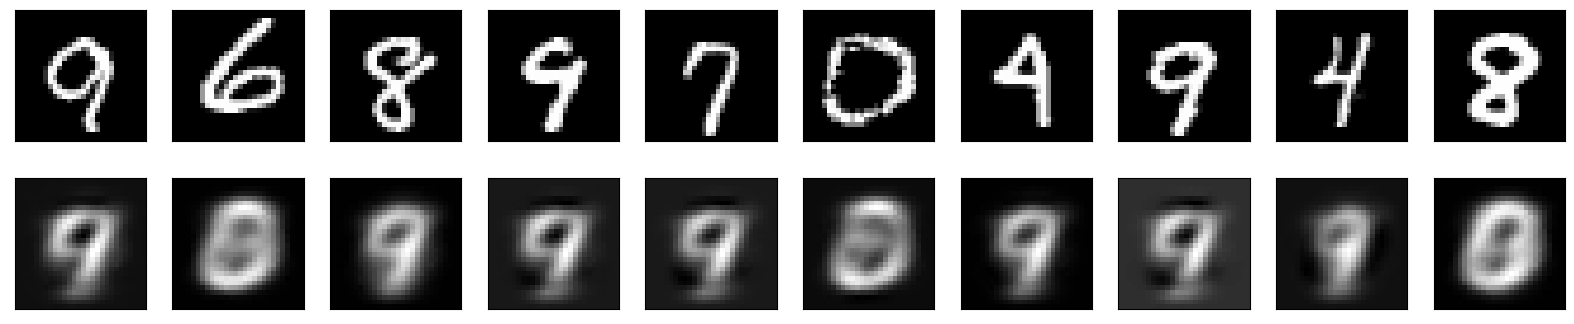

In [40]:
outputs = trained_model.predict(x_test)

plot_reconstructions(x_test, outputs['recon'])

In [ ]:
plot_latent_space(outputs['latent'], y_test)